In [1]:
from federated_learning.dataloader import CIFAR10Dataloader
from federated_learning.configuration import Configuration
import torch 


In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
# Configuration 

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
device = torch.device('cpu')
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
config = Configuration()
cifar = CIFAR10Dataloader(config)
examples = enumerate(cifar.test_dataloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


Files already downloaded and verified
CIFAR10 training loader loaded.
Files already downloaded and verified
CIFAR10 test loader loaded.


torch.Size([1000, 3, 32, 32])

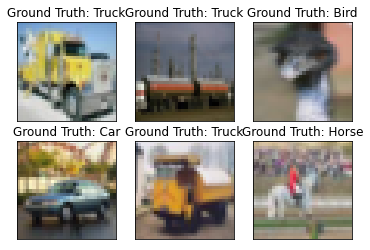

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

fig = plt.figure()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(cifar.train_dataloader)
images, labels = dataiter.next()

for i in range(6):
    plt.subplot(2,3,i+1)
    img = torchvision.utils.make_grid(images[i])
    imshow(img)
    plt.title("Ground Truth: {}".format(cifar.labels[labels[i]]))
    plt.xticks([])
    plt.yticks([])

# Train Model

## Network

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
class CIFAR10CNN(nn.Module):

    def __init__(self):
        super(CIFAR10CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool1(x)

        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.pool2(x)

        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.pool3(x)

        x = x.view(-1, 128 * 4 * 4)

        x = self.fc1(x)
        x = F.softmax(self.fc2(x))

        return x


In [16]:
class CIFARCNN(nn.Module):
    def __init__(self):
        super(CIFARCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [17]:
network = CIFAR10CNN()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [18]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(cifar.train_dataloader.dataset) for i in range(n_epochs)]

In [19]:
# Train and Test Funktions
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(cifar.train_dataloader):
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(cifar.train_dataloader.dataset),100. * batch_idx / len(cifar.train_dataloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(cifar.train_dataloader.dataset)))
            torch.save(network.state_dict(), './results/model.pickel')
            torch.save(optimizer.state_dict(), './results/optimizer.pickel')

def test():
    network.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in cifar.test_dataloader:
            output = network(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            total += 1
    test_loss /= total
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(cifar.test_dataloader.dataset), 100. * correct / len(cifar.test_dataloader.dataset)))

In [20]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/tmp/ipykernel_12622/3936406854.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))



Test set: Avg. loss: 2.3026, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.306907
Train Epoch: 1 [640/50000 (1%)]	Loss: 2.290461
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.268587
Train Epoch: 1 [1920/50000 (4%)]	Loss: 2.224774
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.309009
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.133778
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.169143
Train Epoch: 1 [4480/50000 (9%)]	Loss: 2.163215
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.173236
Train Epoch: 1 [5760/50000 (12%)]	Loss: 2.148655
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.124275
Train Epoch: 1 [7040/50000 (14%)]	Loss: 2.112450
Train Epoch: 1 [7680/50000 (15%)]	Loss: 2.078152
Train Epoch: 1 [8320/50000 (17%)]	Loss: 2.051599
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.002771
Train Epoch: 1 [9600/50000 (19%)]	Loss: 2.027643
Train Epoch: 1 [10240/50000 (20%)]	Loss: 2.074470
Train Epoch: 1 [10880/50000 (22%)]	Loss: 2.052516
Train Epoch: 1 [11520/50000 (23%)]	Loss: 2.023576
Train Epoch: 1 [1216